## GP samples
- This notebook generates samples from a Gaussian Process, trains a 
single layer feedforward network, and stores the weights and biases 

By: Rebecca Gjini

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [2]:
### Functions for GP and Neural network creation ###
# Define RBF kernel
def rbf_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    dists = cdist(x1, x2, metric='sqeuclidean')
    return sigma**2 * np.exp(-dists / (2 * lengthscale**2))

def periodic_distance(nx, lengthscale, sigma):
    C = np.zeros((nx, nx))
    for ii in range(0, nx):
        for jj in range(ii, nx):
            d = np.min([np.abs(ii-jj), -np.abs(ii-jj)%nx])
            C[ii, jj] = sigma**2 * np.exp(-(d/lengthscale)**2);

    return C + C.T -np.diag(np.diag(C))


#Define neural network object
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.Tanh(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)
    

In [ ]:
file_path = "main/l96/nn_mp_weak/GP_pd_20_8/"
# Setup 
d_samples = 100
x = np.linspace(-5.0, 5.0, d_samples).reshape(-1, 1)

# Compute covariance matrix for GP
sigma = 0.5  #0.5
lengthscale = 0.3
# K = rbf_kernel(x, x, sigma, lengthscale)

L = 8.0
PD = periodic_distance(d_samples, L, sigma)

# Network parameters
input_dim = 1
hidden_dim = 20
output_dim = 1

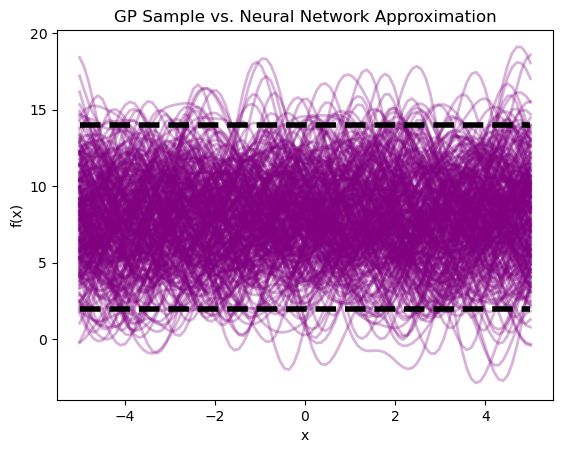

In [15]:
# plt.figure()
# plt.imshow(B)
# plt.show()

plt.figure()
for jj in range(0, 300): 
    np.random.seed(jj)
    y = np.random.multivariate_normal(mean=np.zeros(d_samples), cov=PD)
    plt.plot(x, 8 + 6*y, linewidth=2, color = 'purple', alpha = 0.3)
plt.plot(x, 14*np.ones_like(y), linewidth = 4, linestyle = "dashed", color = "black")
plt.plot(x, 2*np.ones_like(y), linewidth = 4, linestyle = "dashed", color = "black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("GP Sample vs. Neural Network Approximation")
plt.show()

Epoch 0/1100, Loss: 1.073702
Epoch 50/1100, Loss: 0.006361
Epoch 100/1100, Loss: 0.002565
Epoch 150/1100, Loss: 0.002007
Epoch 200/1100, Loss: 0.001609
Epoch 250/1100, Loss: 0.001445
Epoch 300/1100, Loss: 0.001241
Epoch 350/1100, Loss: 0.001011
Epoch 400/1100, Loss: 0.000853
Epoch 450/1100, Loss: 0.000415
Epoch 500/1100, Loss: 0.000098
Epoch 550/1100, Loss: 0.000081
Epoch 600/1100, Loss: 0.000081
Epoch 650/1100, Loss: 0.000081
Epoch 700/1100, Loss: 0.000081
Epoch 750/1100, Loss: 0.000081
Epoch 800/1100, Loss: 0.000081
Epoch 850/1100, Loss: 0.000081
Epoch 900/1100, Loss: 0.000081
Epoch 950/1100, Loss: 0.000081
Epoch 1000/1100, Loss: 0.000081
Epoch 1050/1100, Loss: 0.000081
Training complete for random num:299


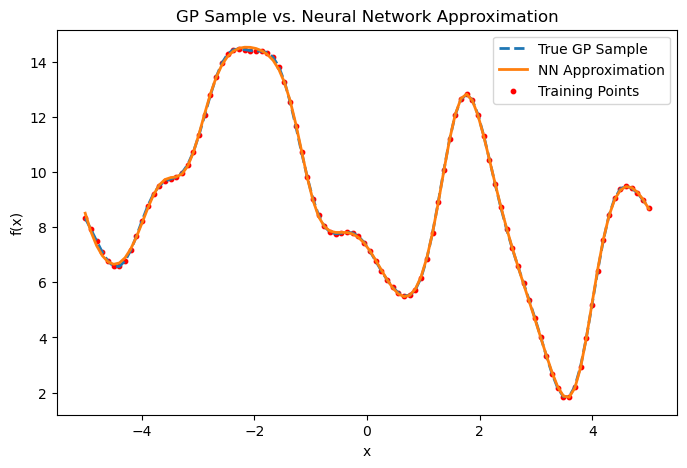

In [40]:
# Generate GP samples and train a NN on them to save weights and biases
num_samples = 299

for ii in range(num_samples, num_samples+1): 
    np.random.seed(ii)
    # Training data
    y = np.random.multivariate_normal(mean=np.zeros(d_samples), cov=PD)
    # Convert to PyTorch tensors
    x_train = torch.tensor(x, dtype=torch.float32)
    y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    model = FeedforwardNN(input_dim, hidden_dim, output_dim)
    # Loss and optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(model.parameters(), lr=2e-2) #

    # epochs = 20000 
    # for epoch in range(epochs):
    #     optimizer.zero_grad()
    #     y_pred = model(x_train)
    #     loss = criterion(y_pred, y_train)
    #     loss.backward()
    #     optimizer.step()
        
    #     if epoch % 2000 == 0:
    #         print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")

    optimizer = optim.LBFGS(model.parameters(), lr=0.03, max_iter=10, history_size=20)
    epochs = 1100

    def closure():
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        return loss

    # Training loop
    for epoch in range(epochs):  # Number of LBFGS steps
        loss = optimizer.step(closure)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")

    print("Training complete for random num:" + f"{ii}")

    # Generate test data
    x_test = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Predict using trained model
    y_test_pred = model(x_test_tensor).detach().numpy()

    # Plot the GP sample and NN approximation
    plt.figure(figsize=(8, 5))
    plt.plot(x, 8 + 6*y, label="True GP Sample", linewidth=2, linestyle="dashed")
    plt.plot(x_test, 8 + 6*y_test_pred, label="NN Approximation", linewidth=2)
    plt.scatter(x, 8 + 6*y, color='red', s=10, label="Training Points")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("GP Sample vs. Neural Network Approximation")
    plt.show()

    # Extract and flatten all parameters
    params = [param.detach().numpy().flatten() for param in model.parameters()]
    flattened_params = np.concatenate(params)

    np.savetxt(file_path + f"sample_{ii}.txt", flattened_params, delimiter = ",")